In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np
from sklearn.decomposition import PCA
import pickle

CIFAR-10 Dataset Preparation and Feature Extraction

This script loads the dataset, extracts features using ResNet-18, and applies PCA

In [ ]:
# Loads CIFAR-10 from PyTorch
# Selects the subset: First 500 training and 100 test images per class
# Extracts features using pre-trained ResNet-18 (creates 512-dim vectors)
# Applies PCA to reduce features from 512 → 50 dimensions
# Saves everything to a pickle file for later use

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load CIFAR-10 Dataset
print("\n=== Loading CIFAR-10 Dataset ===")

# Load full training and test datasets
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                              download=True, transform=None)
testset_full = torchvision.datasets.CIFAR10(root='./data', train=False,
                                             download=True, transform=None)

# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Total training images: {len(trainset_full)}")
print(f"Total test images: {len(testset_full)}")

#Select 500 train + 100 test per class
print("\n=== Selecting subset of images ===")

def select_images_per_class(dataset, num_per_class):
    """
    Select the first 'num_per_class' images from each class.
    Returns images and labels as lists.
    """
    class_counts = {i: 0 for i in range(10)}
    selected_images = []
    selected_labels = []

    for img, label in dataset:
        if class_counts[label] < num_per_class:
            selected_images.append(img)
            selected_labels.append(label)
            class_counts[label] += 1

        # Stop if we have enough from all classes
        if all(count == num_per_class for count in class_counts.values()):
            break

    return selected_images, selected_labels

# Select 500 training images per class (5000 total)
train_images, train_labels = select_images_per_class(trainset_full, 500)
print(f"Selected training images: {len(train_images)}")

# Select 100 test images per class (1000 total)
test_images, test_labels = select_images_per_class(testset_full, 100)
print(f"Selected test images: {len(test_images)}")

# Feature Extraction using ResNet-18
print("\n=== Extracting features using ResNet-18 ===")

# Define transforms for ResNet-18 (resize to 224x224 and normalize)
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Load pre-trained ResNet-18 and remove the last fully connected layer
resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# Remove the final classification layer to get 512-dimensional features
resnet = nn.Sequential(*list(resnet.children())[:-1])
resnet = resnet.to(device)
resnet.eval()  # Set to evaluation mode

print("ResNet-18 loaded (without final layer)")

def extract_features(images, model, transform):
    """
    Extract 512-dimensional feature vectors from images using ResNet-18.
    """
    features = []

    with torch.no_grad():  # No need to compute gradients
        for i, img in enumerate(images):
            # Transform image
            img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

            # Extract features
            feature = model(img_tensor)
            feature = feature.squeeze().cpu().numpy()  # Remove extra dimensions and move to CPU
            features.append(feature)

            if (i + 1) % 500 == 0:
                print(f"Processed {i + 1} images...")

    return np.array(features)

# Extract features for training set
print("Extracting training features")
train_features_512 = extract_features(train_images, resnet, resnet_transform)
print(f"Training features shape: {train_features_512.shape}")

# Extract features for test set
print("Extracting test features")
test_features_512 = extract_features(test_images, resnet, resnet_transform)
print(f"Test features shape: {test_features_512.shape}")

# Apply PCA to reduce from 512 to 50 dimensions
print("\n=== Applying PCA for dimensionality reduction ===")

# Initialize PCA
pca = PCA(n_components=50)

# Fit PCA on training features and transform
train_features_50 = pca.fit_transform(train_features_512)
print(f"Training features after PCA: {train_features_50.shape}")

# Transform test features using the same PCA
test_features_50 = pca.transform(test_features_512)
print(f"Test features after PCA: {test_features_50.shape}")

# Print explained variance
print(f"Explained variance ratio (first 10 components): {pca.explained_variance_ratio_[:10]}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# Save all data
print("\n=== Saving processed data ===")

# Convert labels to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Save features and labels
data_to_save = {
    'train_features_512': train_features_512,
    'test_features_512': test_features_512,
    'train_features_50': train_features_50,
    'test_features_50': test_features_50,
    'train_labels': train_labels,
    'test_labels': test_labels,
    'train_images': train_images,
    'test_images': test_images,
    'classes': classes,
    'pca': pca
}

with open('cifar10_features.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print("Data saved to 'cifar10_features.pkl'")

print("\n=== Data Summary ===")
print(f"Training set: {len(train_labels)} images")
print(f"Test set: {len(test_labels)} images")
print(f"Feature dimensions: 512 (original) -> 50 (after PCA)")
print(f"\nClass distribution in training set:")
for i, class_name in enumerate(classes):
    count = np.sum(train_labels == i)
    print(f"  {class_name}: {count}")

Using device: cpu

=== Loading CIFAR-10 Dataset ===


100%|██████████| 170M/170M [00:19<00:00, 8.91MB/s]


Total training images: 50000
Total test images: 10000

=== Selecting subset of images ===
Selected training images: 5000
Selected test images: 1000

=== Extracting features using ResNet-18 ===
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 77.7MB/s]


ResNet-18 loaded (without final layer)
Extracting training features
Processed 500 images...
Processed 1000 images...
Processed 1500 images...
Processed 2000 images...
Processed 2500 images...
Processed 3000 images...
Processed 3500 images...
Processed 4000 images...
Processed 4500 images...
Processed 5000 images...
Training features shape: (5000, 512)
Extracting test features
Processed 500 images...
Processed 1000 images...
Test features shape: (1000, 512)

=== Applying PCA for dimensionality reduction ===
Training features after PCA: (5000, 50)
Test features after PCA: (1000, 50)
Explained variance ratio (first 10 components): [0.10717501 0.0484568  0.04368815 0.04163815 0.02737131 0.02666458
 0.02313343 0.02074686 0.01981631 0.01685836]
Total explained variance: 0.6796

=== Saving processed data ===
Data saved to 'cifar10_features.pkl'

=== Data Summary ===
Training set: 5000 images
Test set: 1000 images
Feature dimensions: 512 (original) -> 50 (after PCA)

Class distribution in trai

=== Loading preprocessed data ===
Training features shape: (5000, 50)
Test features shape: (1000, 50)

=== Training Custome Naive Bayes (Numpy only) ===
Model trained on 10 classes
Model saved to naive_bayes_custom.pkl

=== Training Scikit-learn Gaussian Naive Bayes ===
Model saved to naive_bayes_sklearn.pkl

EVALUATION RESULTS

Custom Naive Bayes Performance:
  Accuracy:  0.7940
  Precision: 0.7985
  Recall:    0.7940
  F1-Score:  0.7944


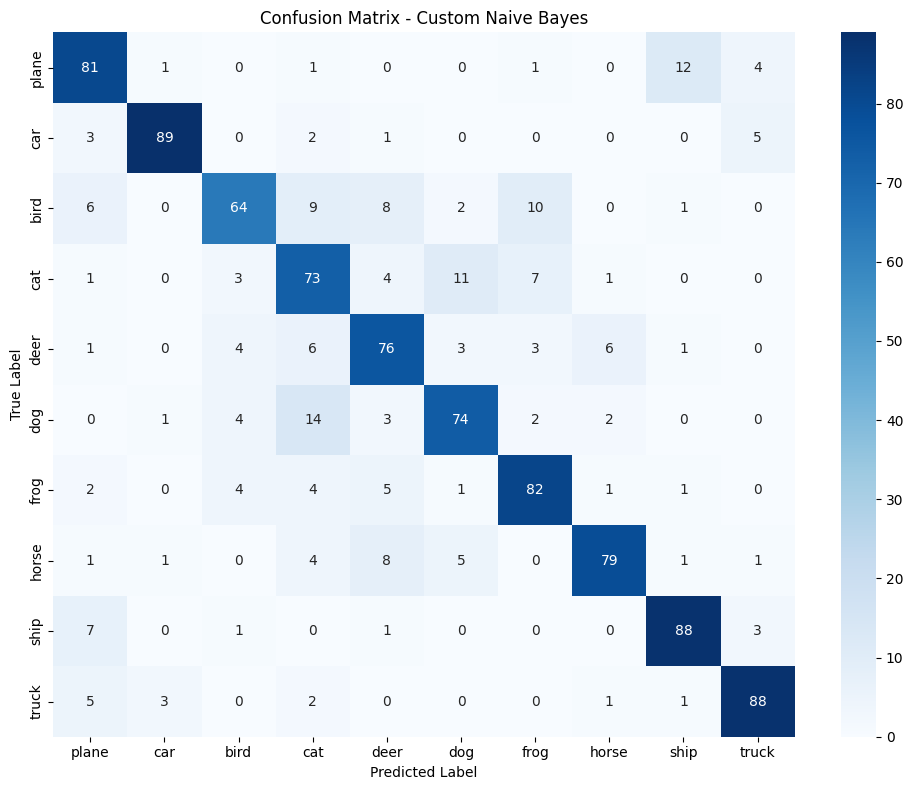

Confusion matrix saved as confusion_matrix_custom_naive_bayes.png

Scikit-learn Naive Bayes Performance:
  Accuracy:  0.7940
  Precision: 0.7985
  Recall:    0.7940
  F1-Score:  0.7944


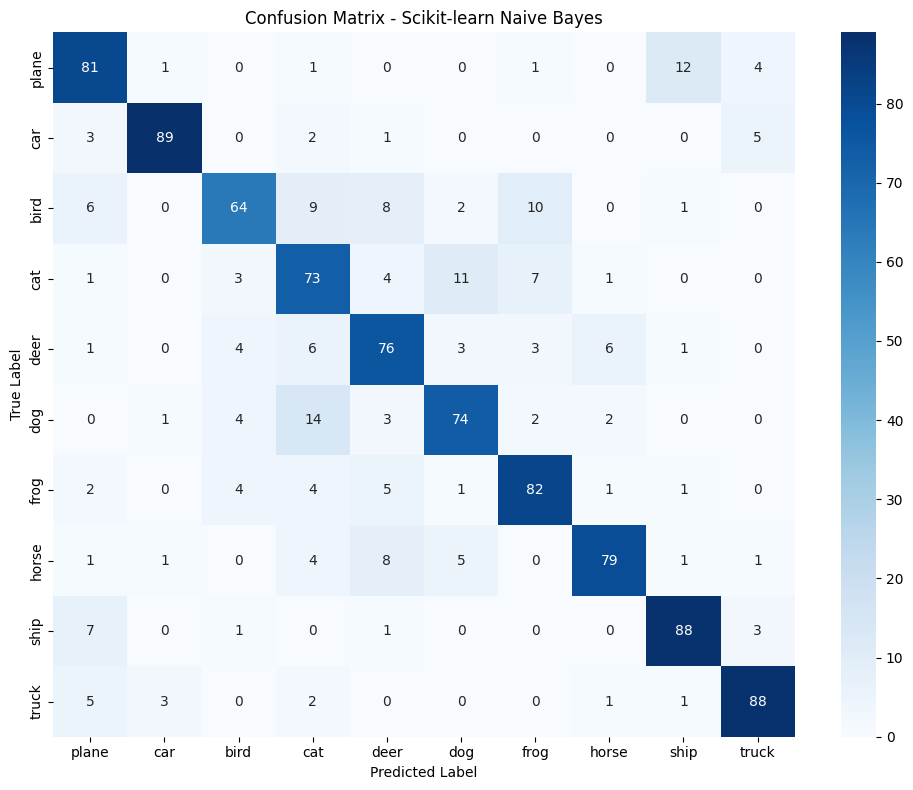

Confusion matrix saved as confusion_matrix_scikit-learn_naive_bayes.png

COMPARISON

Model                          Accuracy     Precision    Recall       F1-Score    
------------------------------------------------------------------------------
Custom Naive Bayes             0.7940       0.7985       0.7940       0.7944      
Scikit-learn Naive Bayes       0.7940       0.7985       0.7940       0.7944      


In [ ]:
# Naive Bayes Classifier for CIFAR-10
# Implements both custom and scikit-learn versions

import numpy as np
import pickle
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed data
print("=== Loading preprocessed data ===")
with open('cifar10_features.pkl', 'rb') as f:
    data = pickle.load(f)

train_features = data['train_features_50']
test_features = data['test_features_50']
train_labels = data['train_labels']
test_labels = data['test_labels']
classes = data['classes']

print(f"Training features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

# Gaussian Naive Bayes Implementation
class GaussianNaiveBayes:
    """
    Gaussian Naive Bayes classifier implementation uses only NumPy.
    """

    def __init__(self):
        self.classes = None
        self.mean = {}  # Mean of features for each class
        self.var = {}   # Variance of features for each class
        self.priors = {}  # Prior probability of each class

    def fit(self, X, y):
        """
        Train the Naive Bayes classifier.

        Args:
            X: Training features (n_samples, n_features)
            y: Training labels (n_samples,)
        """
        self.classes = np.unique(y)
        n_samples = X.shape[0]

        # Calculate statistics for each class
        for c in self.classes:
            # Get all samples belonging to class c
            X_c = X[y == c]

            # Calculate mean and variance for each feature in this class
            self.mean[c] = np.mean(X_c, axis=0)
            self.var[c] = np.var(X_c, axis=0) + 1e-9  # Add small value to avoid division by zero

            # Calculate prior probability P(class)
            self.priors[c] = X_c.shape[0] / n_samples

        print(f"Model trained on {len(self.classes)} classes")

    def _calculate_likelihood(self, x, mean, var):
        """
        Calculate Gaussian likelihood P(x|class).

        Formula: (1 / sqrt(2π * var)) * exp(-(x - mean)^2 / (2 * var))
        """
        eps = 1e-9
        coefficient = 1.0 / np.sqrt(2 * np.pi * var + eps)
        exponent = np.exp(-((x - mean) ** 2) / (2 * var + eps))
        return coefficient * exponent

    def _calculate_posterior(self, x):
        """
        Calculate posterior probability for each class.

        P(class|x) ∝ P(class) * ∏ P(feature_i|class)
        """
        posteriors = {}

        for c in self.classes:
            # Start with prior probability (in log space to avoid underflow)
            posterior = np.log(self.priors[c])

            # Add log likelihood for each feature (assuming independence)
            likelihood = self._calculate_likelihood(x, self.mean[c], self.var[c])
            posterior += np.sum(np.log(likelihood + 1e-9))

            posteriors[c] = posterior

        return posteriors

    def predict(self, X):
        """
        Predict class labels for samples in X.

        Args:
            X: Test features (n_samples, n_features)

        Returns:
            predictions: Predicted class labels (n_samples,)
        """
        predictions = []

        for x in X:
            posteriors = self._calculate_posterior(x)
            # Choose class with highest posterior probability
            predicted_class = max(posteriors, key=posteriors.get)
            predictions.append(predicted_class)

        return np.array(predictions)

    def save_model(self, filename):
        """Save the trained model."""
        model_data = {
            'classes': self.classes,
            'mean': self.mean,
            'var': self.var,
            'priors': self.priors
        }
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filename}")

    def load_model(self, filename):
        """Load a trained model."""
        with open(filename, 'rb') as f:
            model_data = pickle.load(f)
        self.classes = model_data['classes']
        self.mean = model_data['mean']
        self.var = model_data['var']
        self.priors = model_data['priors']
        print(f"Model loaded from {filename}")

#Train Custom Naive Bayes
print("\n=== Training Custome Naive Bayes (Numpy only) ===")
custom_nb = GaussianNaiveBayes()
custom_nb.fit(train_features, train_labels)

# Make predictions
custom_predictions = custom_nb.predict(test_features)

# Save the model
custom_nb.save_model('naive_bayes_custom.pkl')

# Train Scikit-learn Naive Bayes
print("\n=== Training Scikit-learn Gaussian Naive Bayes ===")
sklearn_nb = GaussianNB()
sklearn_nb.fit(train_features, train_labels)

# Make predictions
sklearn_predictions = sklearn_nb.predict(test_features)

# Save the model
with open('naive_bayes_sklearn.pkl', 'wb') as f:
    pickle.dump(sklearn_nb, f)
print("Model saved to naive_bayes_sklearn.pkl")

# Evaluation Functions

def calculate_metrics(y_true, y_pred, model_name):
    """Calculate and print evaluation metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n{model_name} Performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_").lower()}.png', dpi=300)
    plt.show()
    print(f"Confusion matrix saved as confusion_matrix_{model_name.replace(' ', '_').lower()}.png")

# Evaluate Both Models
print("\nEVALUATION RESULTS")

# Evaluate custom implementation
custom_metrics = calculate_metrics(test_labels, custom_predictions, "Custom Naive Bayes")
plot_confusion_matrix(test_labels, custom_predictions, classes, "Custom Naive Bayes")

# Evaluate scikit-learn implementation
sklearn_metrics = calculate_metrics(test_labels, sklearn_predictions, "Scikit-learn Naive Bayes")
plot_confusion_matrix(test_labels, sklearn_predictions, classes, "Scikit-learn Naive Bayes")

# Compare Results
print("\nCOMPARISON")

results_table = [custom_metrics, sklearn_metrics]

print(f"\n{'Model':<30} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 78)
for result in results_table:
    print(f"{result['model']:<30} {result['accuracy']:<12.4f} {result['precision']:<12.4f} "
          f"{result['recall']:<12.4f} {result['f1_score']:<12.4f}")

# Save results for report
with open('naive_bayes_results.pkl', 'wb') as f:
    pickle.dump(results_table, f)

=== Loading preprocessed data ===
Training features shape: (5000, 50)
Test features shape: (1000, 50)

=== Training Custom Decision Tree (max_depth=50) ===
Decision tree trained with max_depth=50
Model saved to decision_tree_custom_depth50.pkl

=== Experimenting with Different Tree Depths ===

Training with max_depth=5...
Decision tree trained with max_depth=5
  Accuracy: 0.5490
Model saved to decision_tree_custom_depth5.pkl

Training with max_depth=10...
Decision tree trained with max_depth=10
  Accuracy: 0.6030
Model saved to decision_tree_custom_depth10.pkl

Training with max_depth=20...
Decision tree trained with max_depth=20
  Accuracy: 0.5850
Model saved to decision_tree_custom_depth20.pkl

Training with max_depth=30...
Decision tree trained with max_depth=30
  Accuracy: 0.5850
Model saved to decision_tree_custom_depth30.pkl

Training with max_depth=50...
Decision tree trained with max_depth=50
  Accuracy: 0.5850
Model saved to decision_tree_custom_depth50.pkl

=== Training Sciki

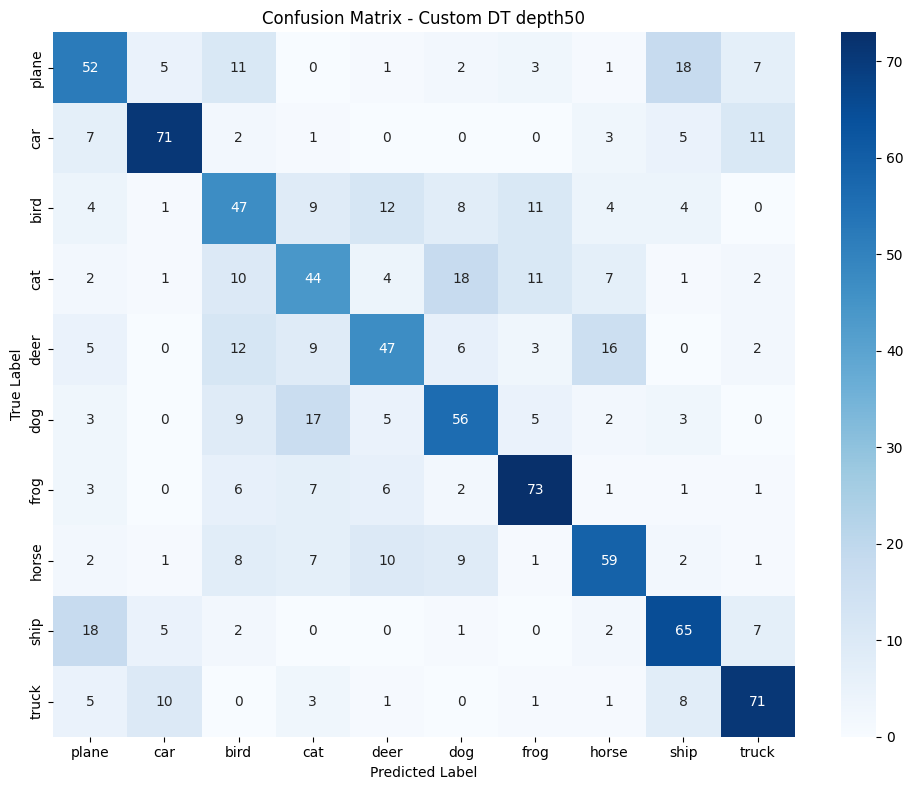

Confusion matrix saved

Scikit-learn DT (depth=50) Performance:
  Accuracy:  0.5830
  Precision: 0.5852
  Recall:    0.5830
  F1-Score:  0.5829


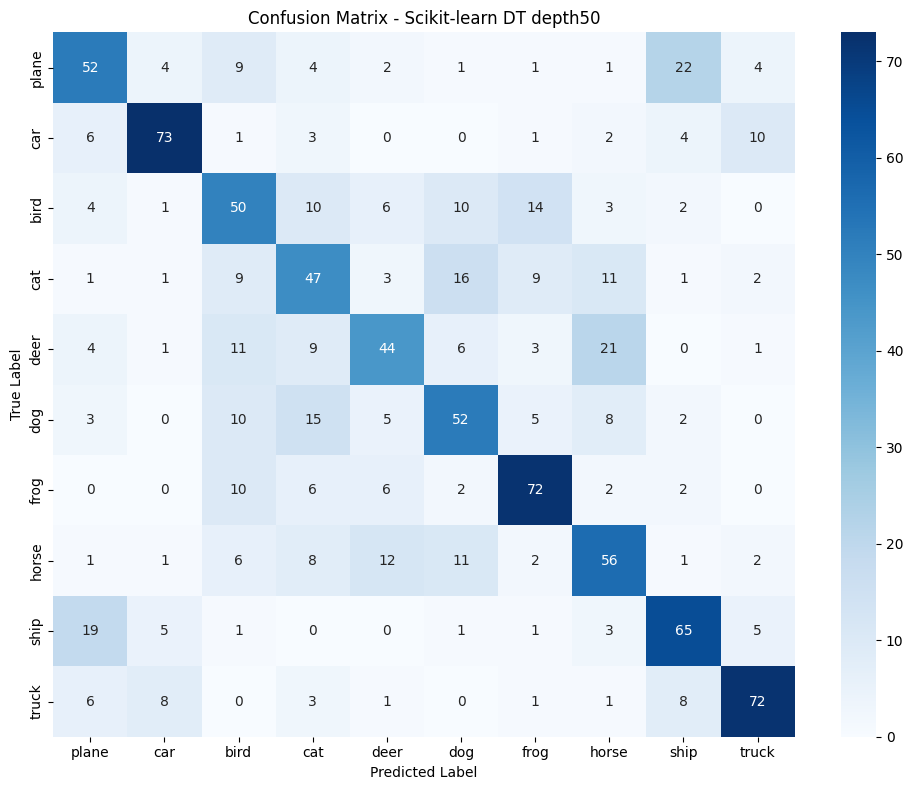

Confusion matrix saved

DEPTH ANALYSIS

Depth      Accuracy    
----------------------
5          0.5490      
10         0.6030      
20         0.5850      
30         0.5850      
50         0.5850      


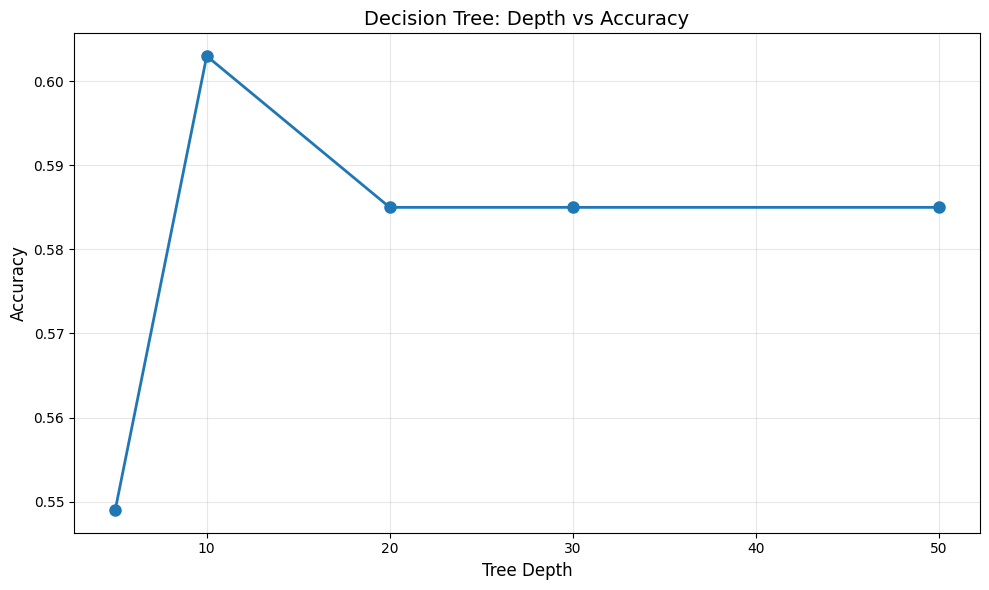

Depth analysis plot saved

SUMMARY

Model                               Accuracy     Precision    Recall       F1-Score    
-----------------------------------------------------------------------------------
Custom DT (depth=50)                0.5850       0.5853       0.5850       0.5845      
Scikit-learn DT (depth=50)          0.5830       0.5852       0.5830       0.5829      


In [ ]:
# Decision Tree Classifier for CIFAR-10
# Implements custom and scikit-learn versions with depth experiments

import numpy as np
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed data
print("=== Loading preprocessed data ===")
with open('cifar10_features.pkl', 'rb') as f:
    data = pickle.load(f)

train_features = data['train_features_50']
test_features = data['test_features_50']
train_labels = data['train_labels']
test_labels = data['test_labels']
classes = data['classes']

print(f"Training features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

# Custom Decision Tree Implementation
class Node:
    """Node in the decision tree."""
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature      # Feature index to split on
        self.threshold = threshold  # Threshold value for split
        self.left = left           # Left subtree
        self.right = right         # Right subtree
        self.value = value         # Class label if leaf node

class DecisionTree:
    """
    Decision Tree classifier using Gini impurity.
    Implements from scratch using only NumPy.
    """

    def __init__(self, max_depth=50, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        """Train the decision tree."""
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        self.root = self._grow_tree(X, y, depth=0)
        print(f"Decision tree trained with max_depth={self.max_depth}")

    def _gini_impurity(self, y):
        """
        Calculate Gini impurity.
        Gini = 1 - Σ(p_i^2) where p_i is proportion of class i
        """
        if len(y) == 0:
            return 0

        proportions = np.bincount(y) / len(y)
        gini = 1.0 - np.sum(proportions ** 2)
        return gini

    def _split_dataset(self, X, y, feature, threshold):
        """Split dataset based on feature and threshold."""
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

    def _best_split(self, X, y):
        """Find the best split using Gini impurity."""
        best_gini = float('inf')
        best_feature = None
        best_threshold = None

        n_samples, n_features = X.shape

        # Try each feature
        for feature in range(n_features):
            # Get unique values for this feature
            thresholds = np.unique(X[:, feature])

            # Try each threshold
            for threshold in thresholds:
                # Split data
                X_left, y_left, X_right, y_right = self._split_dataset(X, y, feature, threshold)

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                # Calculate weighted Gini impurity
                n_left, n_right = len(y_left), len(y_right)
                gini_left = self._gini_impurity(y_left)
                gini_right = self._gini_impurity(y_right)
                weighted_gini = (n_left / n_samples) * gini_left + (n_right / n_samples) * gini_right

                # Update best split
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _grow_tree(self, X, y, depth):
        """Recursively grow the decision tree."""
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping criteria
        if (depth >= self.max_depth or
            n_labels == 1 or
            n_samples < self.min_samples_split):
            # Create leaf node with most common class
            leaf_value = np.argmax(np.bincount(y))
            return Node(value=leaf_value)

        # Find best split
        best_feature, best_threshold = self._best_split(X, y)

        if best_feature is None:
            # No valid split found, create leaf
            leaf_value = np.argmax(np.bincount(y))
            return Node(value=leaf_value)

        # Split the data
        X_left, y_left, X_right, y_right = self._split_dataset(X, y, best_feature, best_threshold)

        # Recursively grow left and right subtrees
        left_subtree = self._grow_tree(X_left, y_left, depth + 1)
        right_subtree = self._grow_tree(X_right, y_right, depth + 1)

        return Node(feature=best_feature, threshold=best_threshold,
                   left=left_subtree, right=right_subtree)

    def _traverse_tree(self, x, node):
        """Traverse tree to make prediction for single sample."""
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

    def predict(self, X):
        """Predict class labels for samples in X."""
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)

    def save_model(self, filename):
        """Save the trained model."""
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
        print(f"Model saved to {filename}")

# Train Custom Decision Tree (max_depth=50)
print("\n=== Training Custom Decision Tree (max_depth=50) ===")
custom_dt_50 = DecisionTree(max_depth=50)
custom_dt_50.fit(train_features, train_labels)

custom_dt_50_predictions = custom_dt_50.predict(test_features)

custom_dt_50.save_model('decision_tree_custom_depth50.pkl')

# Experiment with Different Depths
print("\n=== Experimenting with Different Tree Depths ===")

depths_to_test = [5, 10, 20, 30, 50]
depth_results = []

for depth in depths_to_test:
    print(f"\nTraining with max_depth={depth}...")
    dt = DecisionTree(max_depth=depth)
    dt.fit(train_features, train_labels)

    predictions = dt.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)

    depth_results.append({
        'depth': depth,
        'accuracy': accuracy
    })

    print(f"  Accuracy: {accuracy:.4f}")

    # Save model
    dt.save_model(f'decision_tree_custom_depth{depth}.pkl')

# Train Scikit-learn Decision Tree
print("\n=== Training Scikit-learn Decision Tree (max_depth=50) ===")
sklearn_dt = DecisionTreeClassifier(max_depth=50, criterion='gini', random_state=42)
sklearn_dt.fit(train_features, train_labels)

sklearn_predictions = sklearn_dt.predict(test_features)

with open('decision_tree_sklearn_depth50.pkl', 'wb') as f:
    pickle.dump(sklearn_dt, f)
print("Model saved to decision_tree_sklearn_depth50.pkl")

#Evaluation Functions
def calculate_metrics(y_true, y_pred, model_name):
    """Calculate and print evaluation metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n{model_name} Performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_").lower()}.png', dpi=300)
    plt.show()
    print(f"Confusion matrix saved")

#  Evaluate Models
print("\nEVALUATION RESULTS")

# Evaluate custom implementation (depth=50)
custom_metrics = calculate_metrics(test_labels, custom_dt_50_predictions, "Custom DT (depth=50)")
plot_confusion_matrix(test_labels, custom_dt_50_predictions, classes, "Custom DT depth50")

# Evaluate scikit-learn implementation
sklearn_metrics = calculate_metrics(test_labels, sklearn_predictions, "Scikit-learn DT (depth=50)")
plot_confusion_matrix(test_labels, sklearn_predictions, classes, "Scikit-learn DT depth50")

# STEP 8: Depth Analysis
print("\nDEPTH ANALYSIS")

print(f"\n{'Depth':<10} {'Accuracy':<12}")
print("-" * 22)
for result in depth_results:
    print(f"{result['depth']:<10} {result['accuracy']:<12.4f}")

# Plot depth vs accuracy
plt.figure(figsize=(10, 6))
depths = [r['depth'] for r in depth_results]
accuracies = [r['accuracy'] for r in depth_results]
plt.plot(depths, accuracies, marker='o', linewidth=2, markersize=8)
plt.xlabel('Tree Depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Decision Tree: Depth vs Accuracy', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('decision_tree_depth_analysis.png', dpi=300)
plt.show()
print("Depth analysis plot saved")

# Summary
print("\nSUMMARY")

all_results = [custom_metrics, sklearn_metrics]

print(f"\n{'Model':<35} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 83)
for result in all_results:
    print(f"{result['model']:<35} {result['accuracy']:<12.4f} {result['precision']:<12.4f} "
          f"{result['recall']:<12.4f} {result['f1_score']:<12.4f}")

# Save all results
results_to_save = {
    'main_results': all_results,
    'depth_analysis': depth_results
}

with open('decision_tree_results.pkl', 'wb') as f:
    pickle.dump(results_to_save, f)

Using device: cpu

=== Loading preprocessed data ===
Training features shape: (5000, 50)
Test features shape: (1000, 50)

=== Defining MLP Architecture ===

TRAINING BASE MLP

Training Base MLP...
Epochs: 50, Learning Rate: 0.01
Epoch [10/50], Loss: 0.0756, Accuracy: 0.9850
Epoch [20/50], Loss: 0.0133, Accuracy: 0.9992
Epoch [30/50], Loss: 0.0058, Accuracy: 1.0000
Epoch [40/50], Loss: 0.0106, Accuracy: 0.9992
Epoch [50/50], Loss: 0.0278, Accuracy: 0.9918
Model saved to mlp_base.pth

DEPTH EXPERIMENTS

Training Shallow MLP (2 layers)...
Epochs: 50, Learning Rate: 0.01
Epoch [10/50], Loss: 0.2288, Accuracy: 0.9248
Epoch [20/50], Loss: 0.1080, Accuracy: 0.9760
Epoch [30/50], Loss: 0.0521, Accuracy: 0.9964
Epoch [40/50], Loss: 0.0289, Accuracy: 0.9996
Epoch [50/50], Loss: 0.0191, Accuracy: 1.0000

Training Deep MLP (4 layers)...
Epochs: 50, Learning Rate: 0.01
Epoch [10/50], Loss: 0.0775, Accuracy: 0.9838
Epoch [20/50], Loss: 0.0559, Accuracy: 0.9866
Epoch [30/50], Loss: 0.0308, Accuracy: 

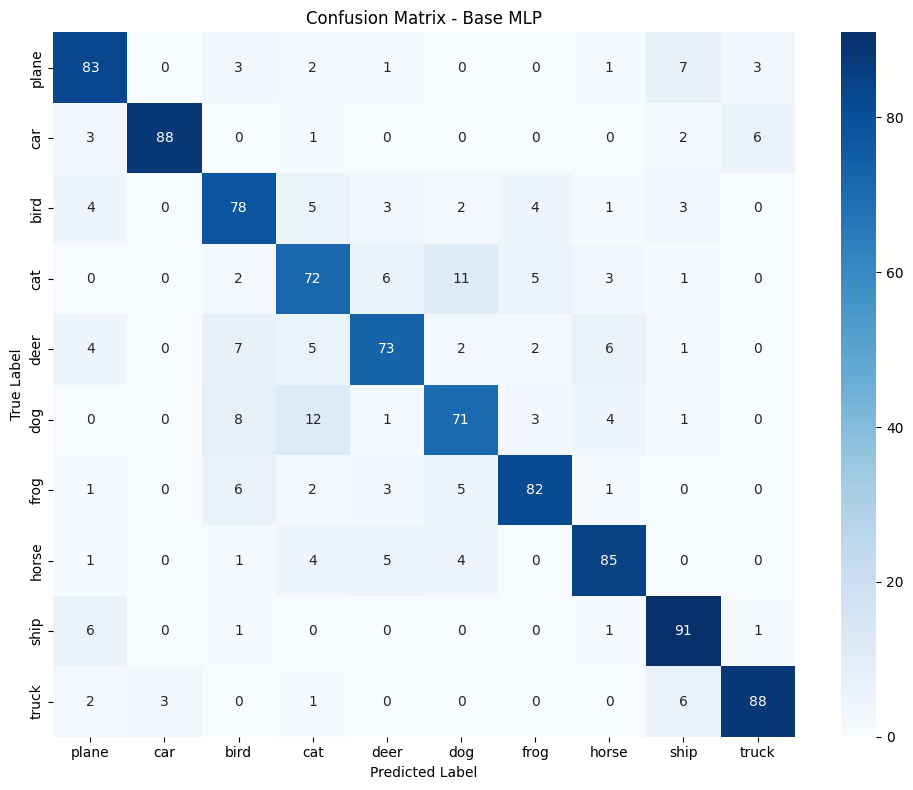


Shallow MLP (2 layers) Performance:
  Accuracy:  0.8310
  Precision: 0.8320
  Recall:    0.8310
  F1-Score:  0.8308


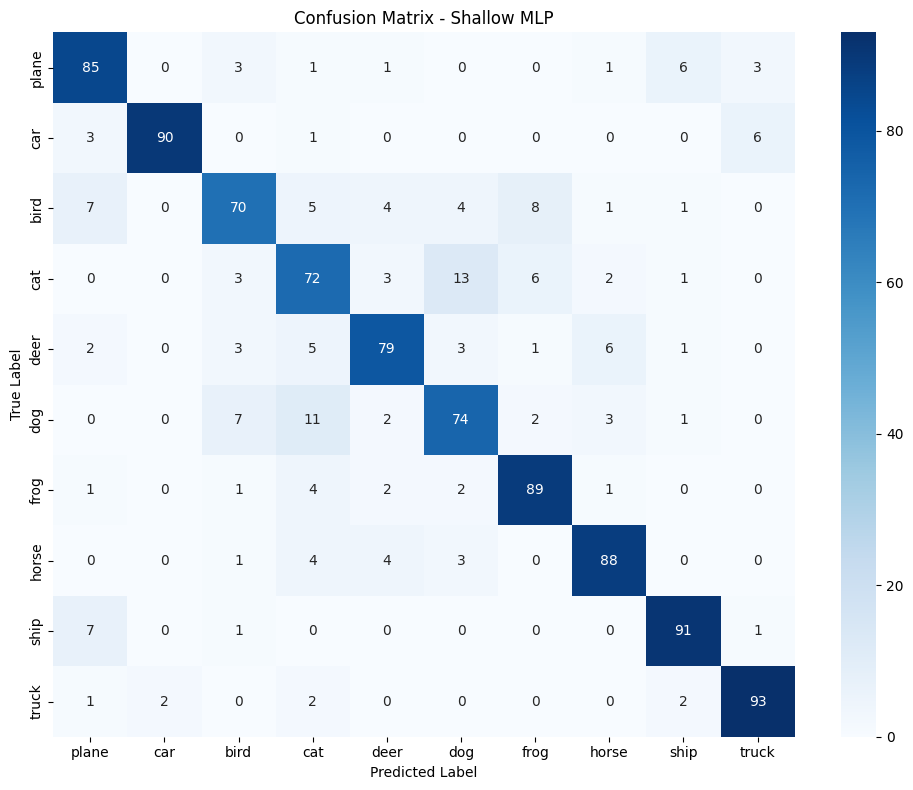


Deep MLP (4 layers) Performance:
  Accuracy:  0.8060
  Precision: 0.8084
  Recall:    0.8060
  F1-Score:  0.8061


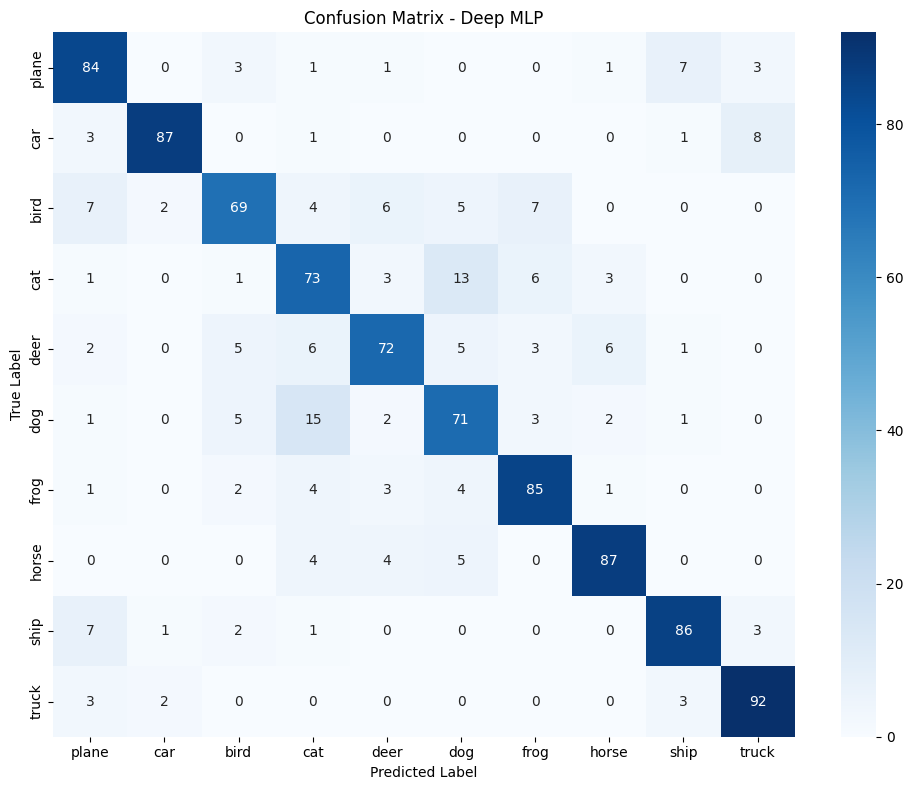


Small MLP (hidden=256) Performance:
  Accuracy:  0.8170
  Precision: 0.8207
  Recall:    0.8170
  F1-Score:  0.8176


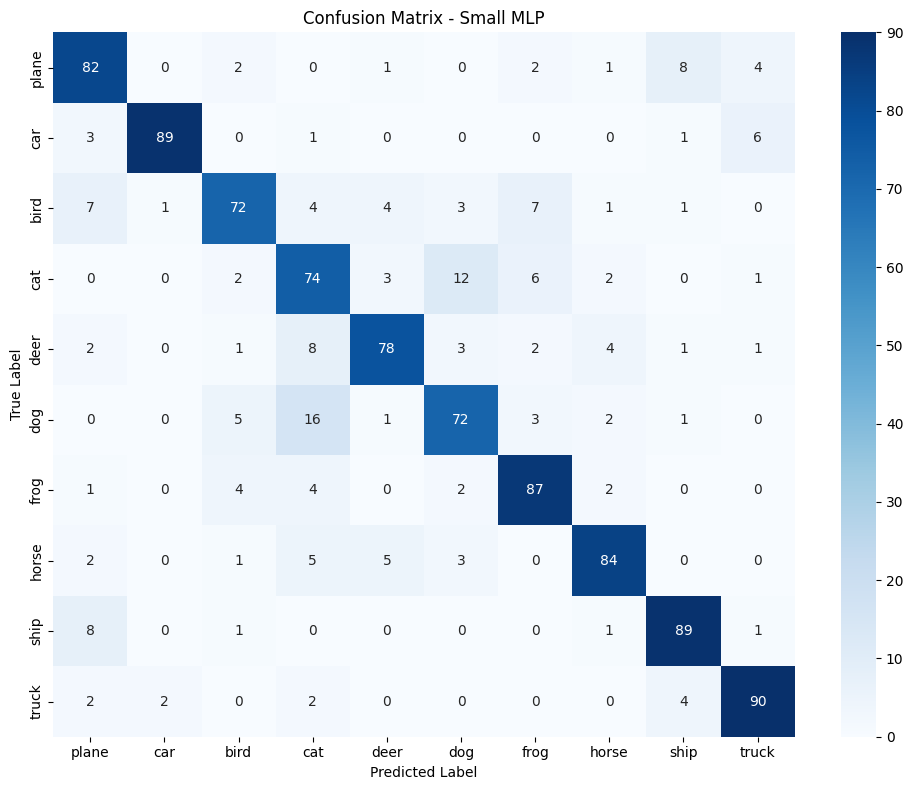


Large MLP (hidden=1024) Performance:
  Accuracy:  0.8300
  Precision: 0.8320
  Recall:    0.8300
  F1-Score:  0.8299


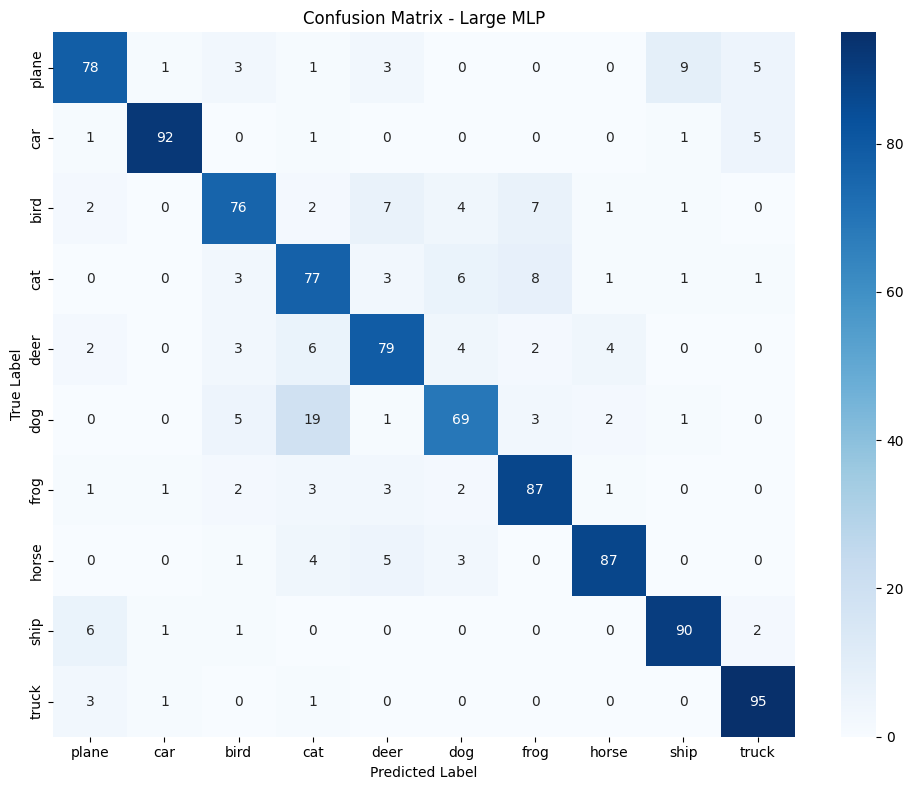


SUMMARY

Model                                    Accuracy     Precision    Recall       F1-Score    
----------------------------------------------------------------------------------------
Base MLP (3 layers, hidden=512)          0.8110       0.8132       0.8110       0.8113      
Shallow MLP (2 layers)                   0.8310       0.8320       0.8310       0.8308      
Deep MLP (4 layers)                      0.8060       0.8084       0.8060       0.8061      
Small MLP (hidden=256)                   0.8170       0.8207       0.8170       0.8176      
Large MLP (hidden=1024)                  0.8300       0.8320       0.8300       0.8299      


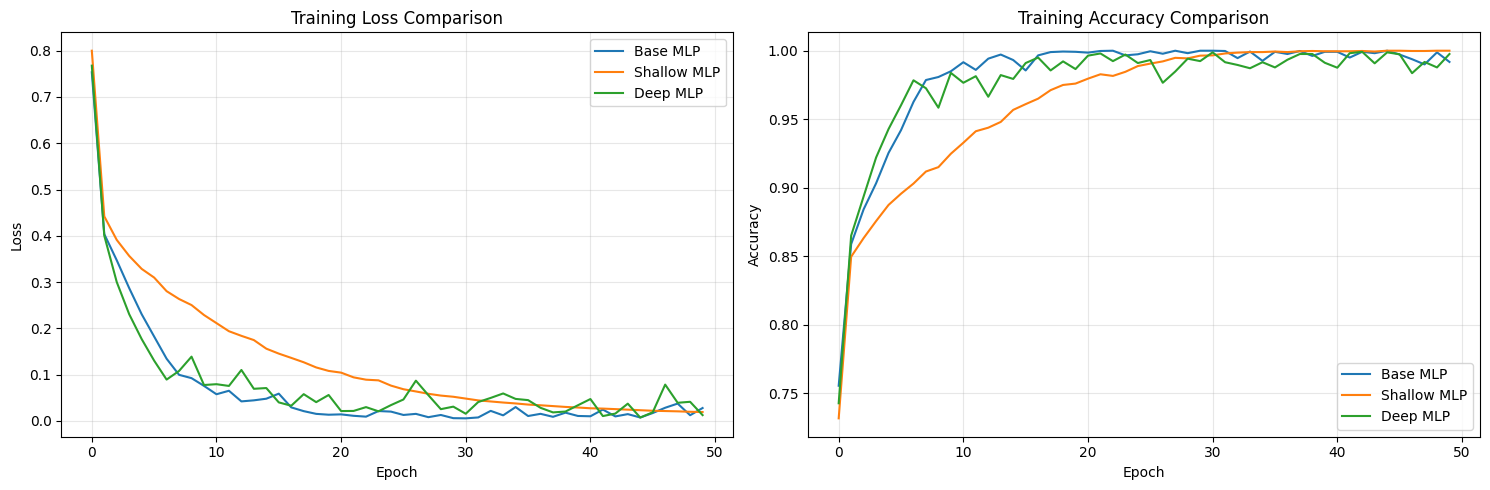

In [ ]:
# Multi-Layer Perceptron (MLP) for CIFAR-10
# PyTorch implementation with depth and size experiments

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load preprocessed data
print("\n=== Loading preprocessed data ===")
with open('cifar10_features.pkl', 'rb') as f:
    data = pickle.load(f)

train_features = data['train_features_50']
test_features = data['test_features_50']
train_labels = data['train_labels']
test_labels = data['test_labels']
classes = data['classes']

print(f"Training features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

# Convert to PyTorch tensors
X_train = torch.FloatTensor(train_features)
y_train = torch.LongTensor(train_labels)
X_test = torch.FloatTensor(test_features)
y_test = torch.LongTensor(test_labels)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define Base MLP Architecture
print("\n=== Defining MLP Architecture ===")

class MLP_Base(nn.Module):
    """
    Base MLP architecture as specified:
    - Linear(50, 512) - ReLU
    - Linear(512, 512) - BatchNorm(512) - ReLU
    - Linear(512, 10)
    """
    def __init__(self):
        super(MLP_Base, self).__init__()

        self.fc1 = nn.Linear(50, 512)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(512, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

#Training Function

def train_model(model, train_loader, num_epochs=50, learning_rate=0.01, model_name="MLP"):
    """Train the MLP model."""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    train_losses = []
    train_accuracies = []

    print(f"\nTraining {model_name}...")
    print(f"Epochs: {num_epochs}, Learning Rate: {learning_rate}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    return model, train_losses, train_accuracies

def evaluate_model(model, test_loader):
    """Evaluate the model and return predictions."""
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_predictions), np.array(all_labels)

# Train Base MLP
print("\nTRAINING BASE MLP")


base_mlp = MLP_Base()
base_mlp, base_losses, base_accs = train_model(base_mlp, train_loader, num_epochs=50,
                                                 learning_rate=0.01, model_name="Base MLP")

# Save model
torch.save(base_mlp.state_dict(), 'mlp_base.pth')
print("Model saved to mlp_base.pth")

# Evaluate
base_predictions, _ = evaluate_model(base_mlp, test_loader)

# Depth Experiments
print("\nDEPTH EXPERIMENTS")

class MLP_Shallow(nn.Module):
    """Shallow MLP - 2 layers"""
    def __init__(self):
        super(MLP_Shallow, self).__init__()
        self.fc1 = nn.Linear(50, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.fc2(x)
        return x

class MLP_Deep(nn.Module):
    """Deeper MLP - 4 layers"""
    def __init__(self):
        super(MLP_Deep, self).__init__()
        self.fc1 = nn.Linear(50, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(512, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(512, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.relu3(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

# Train shallow MLP
shallow_mlp = MLP_Shallow()
shallow_mlp, shallow_losses, shallow_accs = train_model(shallow_mlp, train_loader,
                                                         num_epochs=50, learning_rate=0.01,
                                                         model_name="Shallow MLP (2 layers)")
torch.save(shallow_mlp.state_dict(), 'mlp_shallow.pth')
shallow_predictions, _ = evaluate_model(shallow_mlp, test_loader)

# Train deep MLP
deep_mlp = MLP_Deep()
deep_mlp, deep_losses, deep_accs = train_model(deep_mlp, train_loader,
                                                num_epochs=50, learning_rate=0.01,
                                                model_name="Deep MLP (4 layers)")
torch.save(deep_mlp.state_dict(), 'mlp_deep.pth')
deep_predictions, _ = evaluate_model(deep_mlp, test_loader)

# Hidden Layer Size Experiments
print("\nHIDDEN LAYER SIZE EXPERIMENTS")

class MLP_Small(nn.Module):
    """MLP with smaller hidden layers (256)"""
    def __init__(self):
        super(MLP_Small, self).__init__()
        self.fc1 = nn.Linear(50, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

class MLP_Large(nn.Module):
    """MLP with larger hidden layers (1024)"""
    def __init__(self):
        super(MLP_Large, self).__init__()
        self.fc1 = nn.Linear(50, 1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

# Train small MLP
small_mlp = MLP_Small()
small_mlp, small_losses, small_accs = train_model(small_mlp, train_loader,
                                                   num_epochs=50, learning_rate=0.01,
                                                   model_name="Small MLP (hidden=256)")
torch.save(small_mlp.state_dict(), 'mlp_small.pth')
small_predictions, _ = evaluate_model(small_mlp, test_loader)

# Train large MLP
large_mlp = MLP_Large()
large_mlp, large_losses, large_accs = train_model(large_mlp, train_loader,
                                                   num_epochs=50, learning_rate=0.01,
                                                   model_name="Large MLP (hidden=1024)")
torch.save(large_mlp.state_dict(), 'mlp_large.pth')
large_predictions, _ = evaluate_model(large_mlp, test_loader)

#Evaluation

def calculate_metrics(y_true, y_pred, model_name):
    """Calculate and print evaluation metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n{model_name} Performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_").lower()}.png', dpi=300)
    plt.show()

print("\nEVALUATION RESULTS")

# Evaluate all models
results = []
results.append(calculate_metrics(test_labels, base_predictions, "Base MLP (3 layers, hidden=512)"))
plot_confusion_matrix(test_labels, base_predictions, classes, "Base MLP")

results.append(calculate_metrics(test_labels, shallow_predictions, "Shallow MLP (2 layers)"))
plot_confusion_matrix(test_labels, shallow_predictions, classes, "Shallow MLP")

results.append(calculate_metrics(test_labels, deep_predictions, "Deep MLP (4 layers)"))
plot_confusion_matrix(test_labels, deep_predictions, classes, "Deep MLP")

results.append(calculate_metrics(test_labels, small_predictions, "Small MLP (hidden=256)"))
plot_confusion_matrix(test_labels, small_predictions, classes, "Small MLP")

results.append(calculate_metrics(test_labels, large_predictions, "Large MLP (hidden=1024)"))
plot_confusion_matrix(test_labels, large_predictions, classes, "Large MLP")

# Summary
print("\nSUMMARY")

print(f"\n{'Model':<40} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 88)
for result in results:
    print(f"{result['model']:<40} {result['accuracy']:<12.4f} {result['precision']:<12.4f} "
          f"{result['recall']:<12.4f} {result['f1_score']:<12.4f}")

# Plot training curves comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(base_losses, label='Base MLP')
ax1.plot(shallow_losses, label='Shallow MLP')
ax1.plot(deep_losses, label='Deep MLP')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(base_accs, label='Base MLP')
ax2.plot(shallow_accs, label='Shallow MLP')
ax2.plot(deep_accs, label='Deep MLP')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mlp_training_curves.png', dpi=300)
plt.show()

# Save all results
with open('mlp_results.pkl', 'wb') as f:
    pickle.dump(results, f)

Using device: cpu

=== Loading original images ===
Training images: 5000
Test images: 1000

=== Preparing data for CNN ===
Training tensor shape: torch.Size([5000, 3, 32, 32])
Test tensor shape: torch.Size([1000, 3, 32, 32])

=== Defining VGG11 Architecture specs ===

TRAINING BASE VGG11

Training Base VGG11...
Epochs: 20, Learning Rate: 0.01
Epoch [1/20], Loss: 1.8964, Accuracy: 0.2844
Epoch [2/20], Loss: 1.5372, Accuracy: 0.4366
Epoch [3/20], Loss: 1.3695, Accuracy: 0.5004
Epoch [4/20], Loss: 1.1837, Accuracy: 0.5732
Epoch [5/20], Loss: 1.0118, Accuracy: 0.6390
Epoch [6/20], Loss: 0.8731, Accuracy: 0.6902
Epoch [7/20], Loss: 0.7553, Accuracy: 0.7288
Epoch [8/20], Loss: 0.6403, Accuracy: 0.7806
Epoch [9/20], Loss: 0.5934, Accuracy: 0.8030
Epoch [10/20], Loss: 0.6371, Accuracy: 0.7846
Epoch [11/20], Loss: 0.4073, Accuracy: 0.8712
Epoch [12/20], Loss: 0.4548, Accuracy: 0.8536
Epoch [13/20], Loss: 0.3102, Accuracy: 0.8942
Epoch [14/20], Loss: 0.1906, Accuracy: 0.9398
Epoch [15/20], Loss:

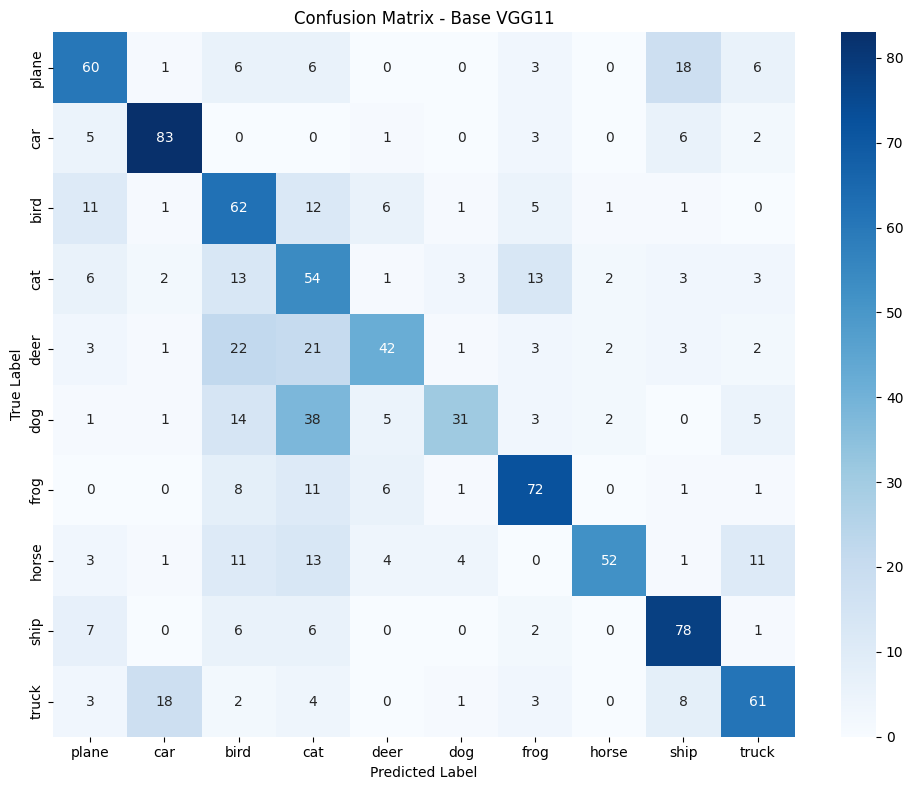


Shallow VGG (6 conv) Performance:
  Accuracy:  0.6200
  Precision: 0.6399
  Recall:    0.6200
  F1-Score:  0.6143


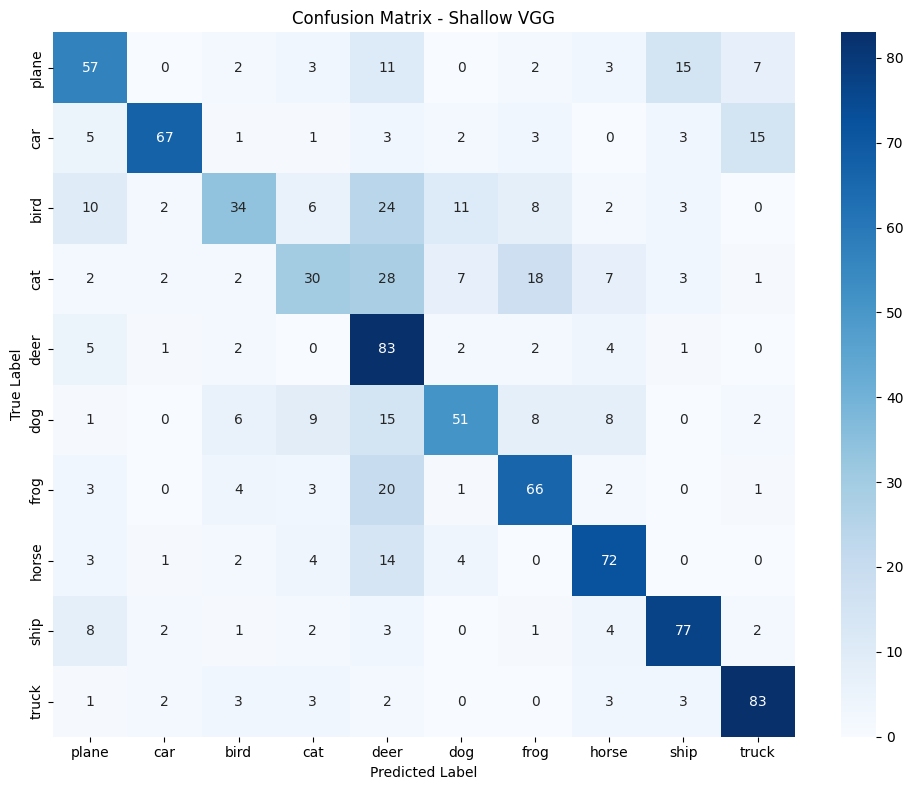


VGG Large Kernel (5x5) Performance:
  Accuracy:  0.6010
  Precision: 0.6083
  Recall:    0.6010
  F1-Score:  0.5938


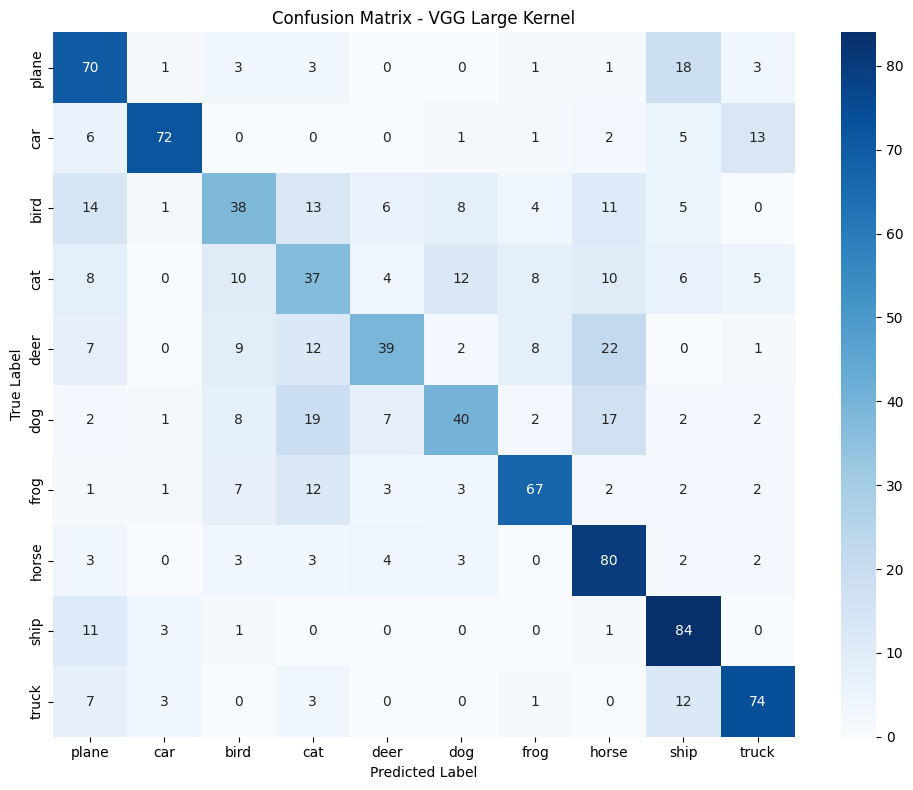


SUMMARY

Model                                    Accuracy     Precision    Recall       F1-Score    
----------------------------------------------------------------------------------------
Base VGG11 (8 conv, 3x3)                 0.5950       0.6389       0.5950       0.5960      
Shallow VGG (6 conv)                     0.6200       0.6399       0.6200       0.6143      
VGG Large Kernel (5x5)                   0.6010       0.6083       0.6010       0.5938      


In [2]:
# VGG11 Convolutional Neural Network for CIFAR-10

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load original images
print("\n=== Loading original images ===")
with open('cifar10_features.pkl', 'rb') as f:
    data = pickle.load(f)

train_images = data['train_images']  # List of PIL images
test_images = data['test_images']
train_labels = data['train_labels']
test_labels = data['test_labels']
classes = data['classes']

print(f"Training images: {len(train_images)}")
print(f"Test images: {len(test_images)}")

# Prepare data for CNN
print("\n=== Preparing data for CNN ===")

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Convert images to tensors
def images_to_tensors(images, transform):
    tensors = []
    for img in images:
        tensor = transform(img)
        tensors.append(tensor)
    return torch.stack(tensors)

X_train = images_to_tensors(train_images, transform)
y_train = torch.LongTensor(train_labels)
X_test = images_to_tensors(test_images, transform)
y_test = torch.LongTensor(test_labels)

print(f"Training tensor shape: {X_train.shape}")
print(f"Test tensor shape: {X_test.shape}")

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define VGG11 Architecture
print("\n=== Defining VGG11 Architecture specs ===")

class VGG11(nn.Module):
    """
    VGG11 architecture
    For CIFAR-10 32x32 images:
    - After 5 MaxPool(2,2): 32 -> 16 -> 8 -> 4 -> 2 -> 1
    - So final feature map is 512 x 1 x 1 = 512
    """
    def __init__(self):
        super(VGG11, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 4
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU()

        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.relu6 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5
        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.relu7 = nn.ReLU()

        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.relu8 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        # After 5 maxpools of 32x32: 32->16->8->4->2->1, so 512x1x1 = 512
        self.fc1 = nn.Linear(512, 4096)
        self.relu_fc1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(4096, 4096)
        self.relu_fc2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool3(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.pool4(x)

        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu7(x)

        x = self.conv8(x)
        x = self.bn8(x)
        x = self.relu8(x)
        x = self.pool5(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu_fc2(x)
        x = self.dropout2(x)

        x = self.fc3(x)

        return x

# Training Function

def train_model(model, train_loader, num_epochs=20, learning_rate=0.01, model_name="VGG11"):
    """Train the CNN model."""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    train_losses = []
    train_accuracies = []

    print(f"\nTraining {model_name}...")
    print(f"Epochs: {num_epochs}, Learning Rate: {learning_rate}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    return model, train_losses, train_accuracies

def evaluate_model(model, test_loader):
    """Evaluate the model and return predictions."""
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_predictions), np.array(all_labels)

#  Train Base VGG11
print("\nTRAINING BASE VGG11")

base_vgg = VGG11()
base_vgg, base_losses, base_accs = train_model(base_vgg, train_loader, num_epochs=20,
                                                learning_rate=0.01, model_name="Base VGG11")

torch.save(base_vgg.state_dict(), 'vgg11_base.pth')
print("Model saved to vgg11_base.pth")

base_predictions, _ = evaluate_model(base_vgg, test_loader)

#  Depth Experiment - Shallow VGG
print("\nDEPTH EXPERIMENT - Removing Conv Layers")

class VGG_Shallow(nn.Module):
    """Shallower VGG - Remove last convolutional block (2 layers)"""
    def __init__(self):
        super(VGG_Shallow, self).__init__()

        # Keep first 6 conv layers, remove last 2
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(128, 256, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 256, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(256, 512, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(512)

        self.conv6 = nn.Conv2d(512, 512, 3, 1, 1)
        self.bn6 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)

        # 4 pools: 32->16->8->4->2, so 512*2*2 = 2048
        self.fc1 = nn.Linear(512 * 2 * 2, 4096)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = nn.ReLU()(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = nn.ReLU()(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = nn.ReLU()(self.bn3(self.conv3(x)))
        x = nn.ReLU()(self.bn4(self.conv4(x)))
        x = self.pool3(x)
        x = nn.ReLU()(self.bn5(self.conv5(x)))
        x = nn.ReLU()(self.bn6(self.conv6(x)))
        x = self.pool4(x)

        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout1(x)
        x = nn.ReLU()(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

shallow_vgg = VGG_Shallow()
shallow_vgg, shallow_losses, shallow_accs = train_model(shallow_vgg, train_loader, num_epochs=20,
                                                         learning_rate=0.01, model_name="Shallow VGG (6 conv)")
torch.save(shallow_vgg.state_dict(), 'vgg_shallow.pth')
shallow_predictions, _ = evaluate_model(shallow_vgg, test_loader)

#Kernel Size Experiment - Large Kernel (5x5)
print("\nKERNEL SIZE EXPERIMENT - Large Kernels (5x5)")

class VGG_LargeKernel(nn.Module):
    """VGG with larger kernels (5x5) in early layers"""
    def __init__(self):
        super(VGG_LargeKernel, self).__init__()

        # Use 5x5 kernels in first few layers, then 3x3
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(512)

        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(2, 2)

        # 5 pools: 32->16->8->4->2->1, so 512x1x1 = 512
        self.fc1 = nn.Linear(512, 4096)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = nn.ReLU()(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = nn.ReLU()(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = nn.ReLU()(self.bn3(self.conv3(x)))
        x = nn.ReLU()(self.bn4(self.conv4(x)))
        x = self.pool3(x)
        x = nn.ReLU()(self.bn5(self.conv5(x)))
        x = nn.ReLU()(self.bn6(self.conv6(x)))
        x = self.pool4(x)
        x = nn.ReLU()(self.bn7(self.conv7(x)))
        x = nn.ReLU()(self.bn8(self.conv8(x)))
        x = self.pool5(x)

        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout1(x)
        x = nn.ReLU()(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

large_kernel_vgg = VGG_LargeKernel()
large_kernel_vgg, lk_losses, lk_accs = train_model(large_kernel_vgg, train_loader, num_epochs=20,
                                                     learning_rate=0.01, model_name="VGG Large Kernel (5x5)")
torch.save(large_kernel_vgg.state_dict(), 'vgg_large_kernel.pth')
large_kernel_predictions, _ = evaluate_model(large_kernel_vgg, test_loader)

# Evaluation Functions

def calculate_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n{model_name} Performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_").lower()}.png', dpi=300)
    plt.show()

# Evaluate All Models
print("\nEVALUATION RESULTS")

results = []
results.append(calculate_metrics(test_labels, base_predictions, "Base VGG11 (8 conv, 3x3)"))
plot_confusion_matrix(test_labels, base_predictions, classes, "Base VGG11")

results.append(calculate_metrics(test_labels, shallow_predictions, "Shallow VGG (6 conv)"))
plot_confusion_matrix(test_labels, shallow_predictions, classes, "Shallow VGG")

results.append(calculate_metrics(test_labels, large_kernel_predictions, "VGG Large Kernel (5x5)"))
plot_confusion_matrix(test_labels, large_kernel_predictions, classes, "VGG Large Kernel")

# Summary
print("\nSUMMARY")

print(f"\n{'Model':<40} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 88)
for result in results:
    print(f"{result['model']:<40} {result['accuracy']:<12.4f} {result['precision']:<12.4f} "
          f"{result['recall']:<12.4f} {result['f1_score']:<12.4f}")

with open('vgg11_results.pkl', 'wb') as f:
    pickle.dump(results, f)